In [194]:
import os
import sys
import scipy.io.wavfile as wavio
scriptpath = "../"
# Add the directory containing your module to the Python path (wants absolute paths)
sys.path.append(os.path.abspath(scriptpath))
from Libs.lcj_io import getDirsInFolder, getFilesInFloder
import numpy as np
import matplotlib.pyplot as plt
import wave
import matplotlib
import datetime
import csv
import pandas as pd
import collections
import librosa
import librosa.display
import IPython.display as ipd
from tqdm import tqdm
import json
import struct

In [235]:
factor_32762 = 32762
one_second_elements = 16000
y_portion_strt= 0
y_portion_end = 8000
s_portion_strt = 0
s_portion_end = 8000

In [205]:
yes_cmd_dir = "../Speech_DataSets/Tensorflow/yes/"
sheila_cmd_dir = "../Speech_DataSets/Tensorflow/sheila/"
whole_kw_dir = "../Speech_DataSets/whole_keyword/"

This sounds like a quantization problem. If samples in the wave file are stored as float and librosa is just performing a straight cast to an int, and value less than 1 will be truncated to 0. More than likely, this is why sig is an array of all zeros. The float must be scaled to map it into range of an int. For example,

>>> a = sp.randn(10)
>>> a
array([-0.04250369,  0.244113  ,  0.64479281, -0.3665814 , -0.2836227 ,
       -0.27808428, -0.07668698, -1.3104602 ,  0.95253315, -0.56778205])
Convert a to type int without scaling

>>> a.astype(int)
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Convert a to int with scaling for 16-bit integer

>>> b = (a* 32767).astype(int)
>>> b
array([ -1392,   7998,  21127, -12011,  -9293,  -9111,  -2512, -42939,
        31211, -18604])
Convert scaled int back to float

>>> c = b/32767.0
>>> c
array([-0.04248177,  0.24408704,  0.64476455, -0.36655782, -0.28360851,
       -0.27805414, -0.0766625 , -1.31043428,  0.9525132 , -0.56776635])
c and b are only equal to about 3 or 4 decimal places due to quantization to int.

If librosa is returning a float, you can scale it by 2**15 and cast it to an int to get same range of values that scipy wave reader is returning. Since librosa is returning a float, chances are the values going to lie within a much smaller range, such as [-1, +1], than a 16-bit integer which will be in [-32768, +32767]. So you need to scale one to get the ranges to match. For example,

sig, rate = librosa.load(spec_file, mono=True)
sig = sig × 32767

In [206]:
def gen_config():
    yes_files = getFilesInFloder(yes_cmd_dir)
    sheila_files = getFilesInFloder(sheila_cmd_dir)
    common_list = []
    cfg_dict_list = []
    for f in yes_files:
        common_list.append(f.split(".")[0])
        
    for f2 in sheila_files:
        common_list.append(f2.split(".")[0])
        
    counter_dict = collections.Counter(common_list)
    for k in counter_dict:
        y_file = yes_cmd_dir+k+".wav"
        s_file = sheila_cmd_dir+k+".wav"
        if os.path.exists(y_file):
            if os.path.exists(s_file):
                cfg_dict = {}
                cfg_dict["prefix_name"] = k
                cfg_dict["yes_file_path"] = y_file
                cfg_dict["ystart_pos"] = 0
                cfg_dict["yend_pos"] = 8000
                cfg_dict["sheila_file_path"] = s_file
                cfg_dict["sstart_pos"] = 0
                cfg_dict["send_pos"] = 8000
                cfg_dict_list.append(cfg_dict)
    with open("../Configs/keyword_combine_config.json","w") as fs:
        json_data = json.dumps(cfg_dict_list)
        fs.writelines(json_data)
        fs.flush()

In [207]:
# gen_config()

In [208]:
def norm_signal(frames):
    return frames/np.max(frames)

In [209]:
def FormatWavSig_MS(norm_sig, sr):
    strt_samp = 0
    end_samp = len(norm_sig)
    end_ms = len(norm_sig)/sr
    xrange = np.linspace(0, end_ms, end_samp-strt_samp)
    return strt_samp, end_samp, end_ms, xrange

In [210]:
# def draw_wav_ms(wav_file):
#     sr, sig = wavio.read(wav_file)
#     sig_norm = norm_signal(sig)
#     start_sample, end_sample

## python function specifies return type 
<strong>def greeting(name: str) -> str:<br/>
 &nbsp;&nbsp;&nbsp;return 'Hello, {}'.format(name)</strong>

In [211]:
def Signal2WAV(sig_array=None, sampleRate=16000, dest_file=None):
    if sig_array is None:
        print("please input valid signals")
        return
    print("input signal length is {}".format(len(sig_array)))
    with wave.open(dest_file,"w")as obj:
        obj.setnchannels(1) # mono
        obj.setsampwidth(2)
        obj.setframerate(sampleRate)
        for value in sig_array:
            value = str(value)
            value = value.replace("\n","")
            value = int(float(value))
            data = struct.pack('<h', value)
            obj.writeframesraw(data)
    print("processing completed.")

In [236]:
def combine_signals(sig1,sig2):
    mix_ary = np.zeros(one_second_elements,order='F')
    sig1_len = len(sig1)
    sig2_len = len(sig2)
    for s1 in range(sig1_len):
        mix_ary[s1] = sig1[s1]
    for s2 in range(sig2_len):
        mix_ary[sig1_len+s2] = sig2[s2]
    return mix_ary 

In [237]:
def concatenate_wav(prefixname = None, yfile=None, sfile= None):
    ysr, ysignal = wavio.read(yfile)
    ssr, ssignal = wavio.read(sfile)
    
    
    ynorm = norm_signal(ysignal)
    snorm = norm_signal(ssignal)
    
    y_strt_samp = 0
    y_end_samp = len(ynorm)
    y_end_ms = len(ynorm)/ysr
    
    s_strt_samp = 0
    s_end_samp = len(snorm)
    s_end_ms = len(snorm)/ssr
    
    y_xrange = np.linspace(0, y_end_ms, y_end_samp-y_strt_samp)
    s_xrange = np.linspace(0, s_end_ms, s_end_samp-s_strt_samp)
    
    fg1 = plt.figure(figsize=(18, 8))
    plt.plot(y_xrange, ynorm)
    plt.xlabel('Time in seconds')
    plt.ylabel('Amplitude')
    plt.axis('tight')
    
    fg2 = plt.figure(figsize=(18, 8))
    plt.plot(s_xrange, snorm)
    plt.xlabel('Time in seconds')
    plt.ylabel('Amplitude')
    plt.axis('tight')
    
    y_half_sig = ysignal[y_portion_strt:y_portion_end]
    s_half_sig = ssignal[s_portion_strt:s_portion_end]
    combinedsig = combine_signals(y_half_sig,s_half_sig)
    cnorm = norm_signal(combinedsig)
    c_strt_samp, c_end_samp, c_end_ms, c_xrange = FormatWavSig_MS(cnorm,16000)
    
    fg3 = plt.figure(figsize=(18, 8))
    plt.plot(c_xrange, cnorm)
    plt.xlabel('Time in seconds')
    plt.ylabel('Amplitude')
    plt.axis('tight')
    
    to_write_wav = whole_kw_dir+prefixname+".wav"
    Signal2WAV(combinedsig,dest_file=to_write_wav)
#     mix_ary2 = np.zeros(one_second_elements,order='F')
#     print(mix_ary2.shape)


In [238]:
"""ipd.Audio(test_y_file)
winlen = int(samp_freq*.03)  # Window size of 30 ms
X = librosa.stft(
    np.array(speech_samples_norm[strt_samp:end_samp]), win_length=winlen)
Xdb = librosa.amplitude_to_db(abs(X))
fg2 = plt.figure(figsize=(18, 8))
librosa.display.specshow(Xdb, sr=samp_freq, x_axis='time',
                         y_axis='hz', hop_length=winlen/4)
"""

"ipd.Audio(test_y_file)\nwinlen = int(samp_freq*.03)  # Window size of 30 ms\nX = librosa.stft(\n    np.array(speech_samples_norm[strt_samp:end_samp]), win_length=winlen)\nXdb = librosa.amplitude_to_db(abs(X))\nfg2 = plt.figure(figsize=(18, 8))\nlibrosa.display.specshow(Xdb, sr=samp_freq, x_axis='time',\n                         y_axis='hz', hop_length=winlen/4)\n"

In [239]:
# process_main()
test_y_file = "../Speech_DataSets/Tensorflow/yes/40115b19_nohash_0.wav"
test_s_file = "../Speech_DataSets/Tensorflow/sheila/40115b19_nohash_0.wav"

In [240]:
# play "yse"
# ipd.Audio(test_y_file)

In [241]:
# play sheila
# ipd.Audio(test_s_file)

input signal length is 16000
processing completed.


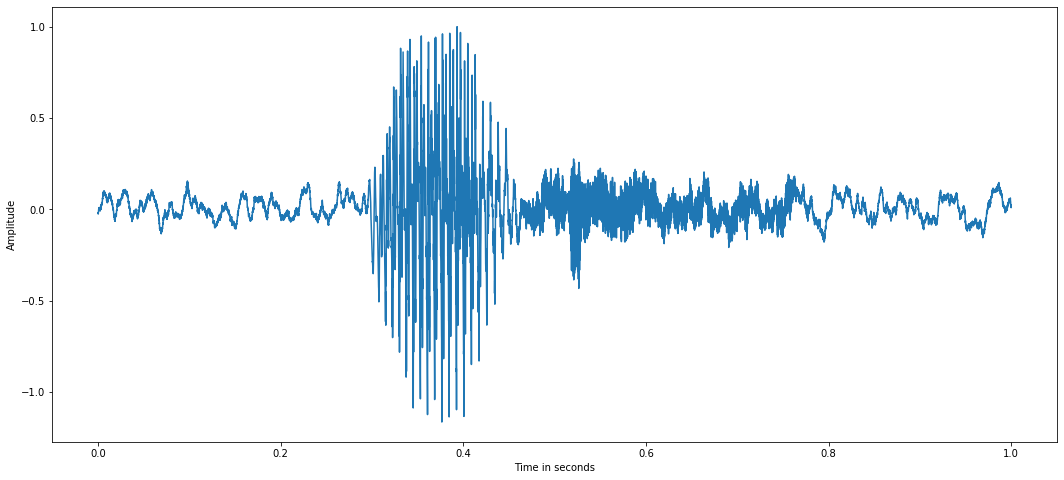

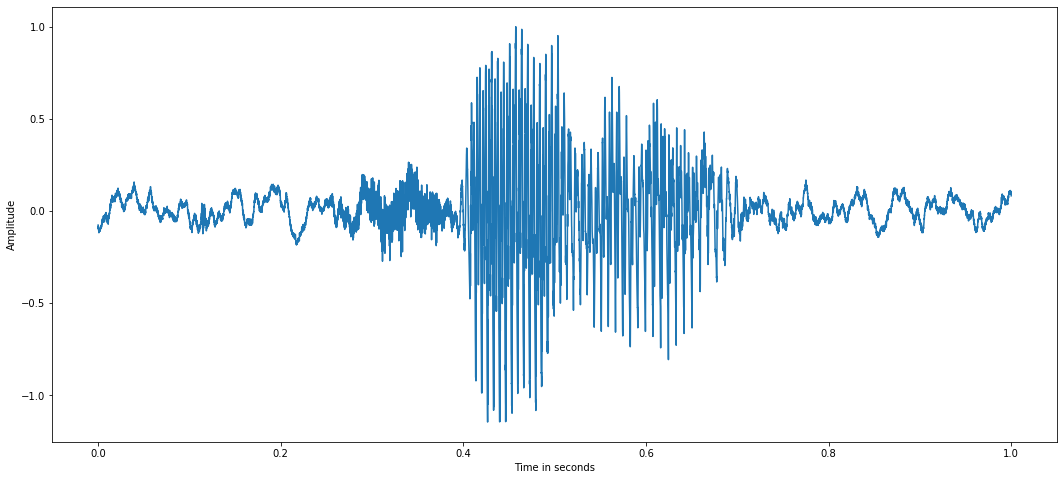

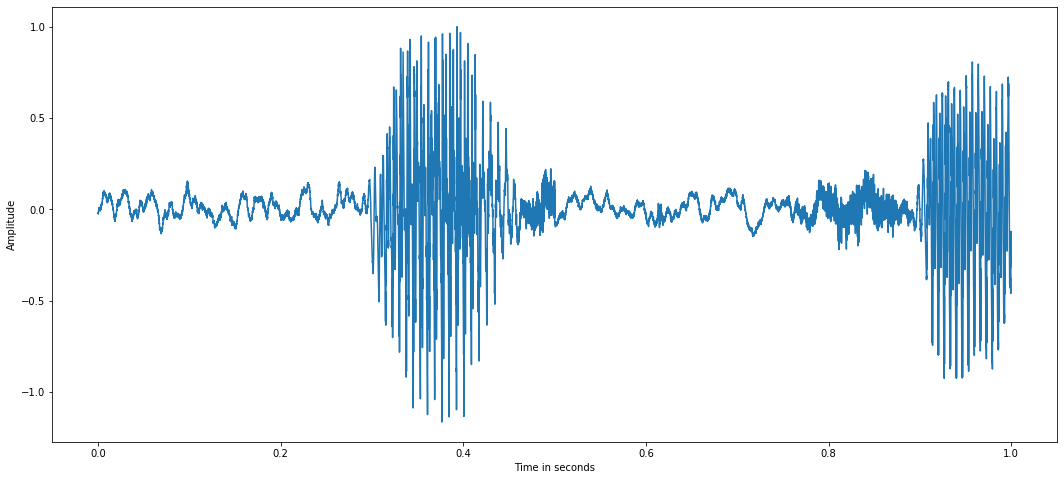

In [242]:
concatenate_wav("40115b19_nohash_0",test_y_file,test_s_file)

In [ ]:
def process_main():
    #read config
    config_file = "../Configs/keyword_combine_config.json"
    